# <center>Digital Image Processing - Problem Set 6</center>

### Student Names: Catherine Díaz & Sorelys Sandoval

In [1]:
# Import all the libraries needed
from os import listdir, path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools

%matplotlib inline
testing_files = listdir('testing_set')[1:]
training_files = listdir('training_set')[1:]
binaryTraining_files = listdir('training_set/Binarized Images')
binaryTesting_files = listdir('testing_set/Binarized Images')

### Problem 1

Write a function that performs object recognition using $k$-Nearest Neighbors ($k$-NN). You can (and are encouraged to) use the functions
you have written for previous exercises. Your function should run the following steps:

1. Binarize the images in the training set. Use an appropriate threshold when binarizing each image. You can use an adaptive thresholding technique. Perform binarization such that pixels on the object of interest are equal to 1 and background pixels are equal to 0.
2. Describe each object in the training set using Hu moments. This results in one feature vector per object.
3. Repeat the two previous steps for the all images in the training set.
4. The $k$-NN classifier predicts a category for each testing example according to the following steps:
    1. Pick an image from the testing set.
    2. Compute the distance from the feature vector associated to the testing example to all the descriptors from the training set.
    3. Select the closest $k$ training examples (that is, the $k$ training examples with shortest distance to our testing image).
    4. Find the object category associated to each of the $k$ training examples. This information is given to you in the training set.
    5. Assign a label to the testing image. The assigned label is equal to the most common label among the $k$ closes training examples.
    
5. Repeat this process for all testing examples. Compute the accuracy of the classifier in terms of the number of correctly classified testing examples over the total number of examples in the testing set.

You should test your functions with the three object classes <tt> key, chip, pen</tt>. Compare the difference in performance between a 1-NN classifier, a 3-NN classifier and a $k$-NN classifier. Summarize the performance of each classifier using confusion matrices.

In [45]:
class kNN_Clasifier():
    """ Clase que construye un clasificador k-NN dependiendo de la versión de OpenCV."""
    def __init__(self):
        if cv2.__version__ < 3:
            self.model = cv2.KNearest()
        else:
            self.model = cv2.ml.KNearest_create()

    def preprocess(self,image):
        """ Función que realiza la binarización inversa de una imagen de entrada.
        Input:  image: numpy array con la imagen (escala de grises).
        ====== 
        Output:   out: numpy array con la imagen binarizada.
        ====== 
        """
        blur = cv2.medianBlur(image,5)
        out = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,255,2)
        out = cv2.medianBlur(out,3)
        struc = np.ones((3,3),np.uint8)
        out = cv2.dilate(out, struc, iterations = 1)
        return out
    
    def HuMoments(self,image):
        """ Función que describe los momentos estadisticos Hu de cada objeto en una imagen binaria.
        Input:  image: numpy array con la imagen (binaria).
        ====== 
        Output:   out: arreglo con los 7 momentos Hu por cada objeto hallado.
        ====== 
        """
        M = cv2.moments(image)
        out = cv2.HuMoments(M)
        return out.flatten()
    
    def train(self,trainData,responses):
        """ Función que entrena el clasificador k-NN.
        Input:  trainData: lista con los features de cada imagen de entrenamiento.
        ======  responses: lista con el label de cada imagen de entrenamiento.
        """
        trainData = np.array(trainData, dtype='float32')
        responses = np.array(responses, dtype='float32')
        if cv2.__version__ < 3:
            self.model.train(trainData,responses)
        else:
            self.model.train(trainData,cv2.ml.ROW_SAMPLE,responses)
    
    def test(self, data,k=3):
        """ Función que predice la clase de uno o varios vectores de features con parámetro k 3 por default.
        Input:  data: lista con los features de cada imagen a clasificar.
        ======      k: entero que indica el número de elementos cercanos al que se intenta clasificar.
        
        Output:   results: lista con el label predicho de cada dato ingresado.
        ====== 
        """
        data = np.array(data, dtype='float32')
        if cv2.__version__ < 3:
            _, results, _, _ = self.model.find_nearest(data, k)
        else:      
            _, results, _, _ = self.model.findNearest(data, k)
        return results.ravel()
    
    def confusionMatrix(self,classes,labels,results,title='Matriz de confusion'):
        confusion = np.zeros((3,3), np.int32)
        for i, j in zip(labels, results):
            confusion[int(i),int(j)] += 1  
        plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues); plt.title(title); plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        # Normalizing the matrix
        confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
        thresh = confusion.max() / 2.
        for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
            plt.text(j, i, confusion[i, j],
                     horizontalalignment="center",
                     color="white" if confusion[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
    def clasify(self, image,k=3):
        """ Función que predice la clase de una imagen de entrada con parámetro k 3 por default.
        Input:  image: numpy array con la imagen (escala de grises).
        ======      k: entero que indica el número de elementos cercanos al que se intenta clasificar.
        
        Output:   out: label predicho de la imagen ingresada.
        ====== image2: imagen preprocesada
                 data: vector de features de image2
        """
        image2 = self.preprocess(image.copy())
        data = [self.HuMoments(image2)]
        out = self.test(data,k)
        return out, image2, data

<p><em><strong>Nota: </strong></em>Es necesario aclarar que se realizó una clase <strong>kNN_Clasifier</strong> debido a que teníamos diferentes versiones de OpenCV en nuestros computadores y el método de OpenCV que crea el clasificador tiene diferentes sintaxis en la versión 2 y 3. Además que nos pareció mucho más ordenado y de hecho nos guiamos de <a href="http://code.metager.de/source/xref/lib/opencv/samples/python2/digits.py#KNearest">[1]</a> el cual encontramos buscando la nueva sintaxis de knearest en OpenCV 3.
<p><em><strong>Funcionalidad del c&oacute;digo: </strong></em> En la primera secci&oacute;n, la primera funci&oacute;n llamada <strong>__init__</strong> es el constructor de la clase y se encarga de que el modelo que se desea generar se pueda hacer, teniendo en cuenta la versi&oacute;n de opencv que tenga el computador, para que pueda operar tanto en computadores con opencv2 como opencv3, esto por medio de un condicional que verifica cual versi&oacute;n se tiene y dependiendo de eso se aplica una funci&oacute;n u otra.</p>
<p>La siguiente funci&oacute;n se llama <strong>preprocess</strong>, y como su nombre lo indica es el pre procesamiento por el que debe pasar la imagen, primero se aplica un suavizado seguido de una binarizaci&oacute;n por un threshold adaptativo, el cual es un poco m&aacute;s r&aacute;pido que el que se hab&iacute;a utilizado un par de talleres atr&aacute;s. As&iacute; mismo se escogieron los par&aacute;metros de esta funci&oacute;n, para que la imagen resultante fuese una binaria invertida. Para que el resultado se viera un poco mejor, se filtra de forma suave para eliminar algo de ruido sin perder mucha definici&oacute;n de la imagen, luego esta se dilata de modo que otras irregularidades y huecos desaparezcan.</p>
<p>Algo que se puede mencionar de esta secci&oacute;n es que debido al taller de filtros que se hizo anteriormente, se escogieron valores de 3 y 5 para el kernel de los suavizados, dado que en estos se vio que los resultados con estos eran mejores para casos como este. Adem&aacute;s, el filtrado antes de la dilataci&oacute;n es importante debido a que si no se realiza, esta operaci&oacute;n morfol&oacute;gica har&iacute;a que las peque&ntilde;as imperfecciones producto de ruido sean m&aacute;s notables.</p>
<p>La siguiente funci&oacute;n es <strong>HuMoments</strong>, la cual es muy similar a la empleada en el taller pasado, con la diferencia que en el taller pasado se deb&iacute;a tener en cuenta si la imagen ten&iacute;a m&aacute;s de un objeto, cosa que no es necesaria en este caso porque las im&aacute;genes empleadas tienen un solo objeto y solo perder&iacute;a m&aacute;s tiempo intentando hacer lo aplicado en el taller anterior. El resultado se devuelve usando un .flatten que organiza los resultados de forma deseada (vector).</p>
<p>La funci&oacute;n <strong>train</strong> es como su nombre da a entender la encargada del entrenamiento que necesita el objeto de la clase kNN_Clasifier. Esta recibe un arreglo con todos los momentos Hu de todas las im&aacute;genes, as&iacute; como una tabla con los features de las im&aacute;genes y un vector con las clases que corresponden a cada imagen.</p>
<p>El objetivo de la funci&oacute;n que sigue, <strong>test</strong>, es predecir cu&aacute;l debe ser la clase. El m&eacute;todo de encontrar el vecino m&aacute;s cercano es empleado, a esto se le ingresan los atributos y el valor de k. Se escogió el valor de 3 como default, debido a que realizando pruebas se obtenían mejores resultados con este. Por &uacute;ltimo, los resultados se entregan usando un .ravel que acondiciona un poco los datos para poder iterar sobre ellos.</p>
<p>La siguiente funci&oacute;n es <strong>confusionMatrix</strong>, que como se sabe es una matriz para comparar el n&uacute;mero de aciertos y errores en la clasificaci&oacute;n por parte del algoritmo. Esto se grafica sabiendo los resultados del algoritmo (eje x) contra los resultados esperados (lado izquierdo). Esta matriz se encuentra normalizada como se podr&aacute; apreciar, para mostrar un porcentaje y facilitar las comparaciones aun con condiciones no exactamente iguales. Para la realización de esta función nos guiamos de <a href="http://code.metager.de/source/xref/lib/opencv/samples/python2/digits.py#KNearest">[1]</a> y <a href="http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html">[2]</a></p>
<p>Para implementar esta clase es necesario crear el objeto de la clase kNN_Clasifier, el cual llamamos __knn__. Se procede a obtener el vector de features de las im&aacute;genes de entrenamiento y el vector de responses que contiene los labels respectivos a cada imagen. Para ello, claramente hay que usar las funciones de preprocesamiento y descripción de las imágenes.</p>
<p> Se entrena el modelo llamando la función train y luego se construyen los datos de prueba, los cuales se obtienen de la misma forma que los de entrenamiento pero usando el grupo de imagenes de testing.</p>
<p>Para la parte de evaluación se realizó un ciclo en donde en cada iteración se cambiaba de valor de k (1,3,9 y 11) y se llamaba a la función de test del objeto knn.</p>
<p>Los resultados obtenidos se grafican contra los resultados reales como ya se mencion&oacute; para la matriz de confusi&oacute;n</p>

<p><em><strong>Funciones empleadas y descripci&oacute;n: </strong></em></p>
<p>La funci&oacute;n <strong>cv2.KNearest() </strong>construye el clasificador kNN a emplear.</p>
<p>Con la funci&oacute;n <strong>cv2.adaptiveThreshold() </strong>se binarizan las im&aacute;genes. En esta es importante que el tercer par&aacute;metro es ADAPTIVE_THRESH_MEAN_C, porque esto indica que el valor empleado para demarcar el umbral es la media de los vecinos. El cuarto par&aacute;metro tambi&eacute;n es importante ya que en este caso diferente a como se hab&iacute;a realizado en los talleres anteriores se escoge la opci&oacute;n THRESH_BINARY_INV ya que se desea la binarizaci&oacute;n inversa de la imagen como se mencion&oacute; arriba.</p>
<p>La funci&oacute;n<strong> .flatten()</strong> toma matrices y acomoda los datos en un solo vector.</p>
<p>La funci&oacute;n <strong>.ravel()</strong> toma matrices y acomoda los datos en un vector, pero lo puede hacer en distinto orden dependiendo de los argumentos.</p>
<p><strong>cv2.KNearest.train() </strong>entrena el modelo con los vectores de features de cada elemento y su respectiva clase. Aquí hacemos referencia a elemento y no imagen, porque el clasificador de K-vecinos más cercanos no solo se aplica para imágenes.</p>
<p><strong>cv2.KNearest.find_nearest()</strong> predice o clasifica el vector de features ingresado, el segundo argumento k se refiere al n&uacute;mero de vecinos en los que se va a basar para realizar la clasificaci&oacute;n. Cabe resaltar que no se emplean todas las salidas que arroja el método, sino solamente se usa el vector de resultados que contiene las predicciones del modelo. De igual forma la dem&aacute;s informaci&oacute;n es &uacute;til para otras aplicaciones pero no para esta en espec&iacute;fico.</p>
</p>

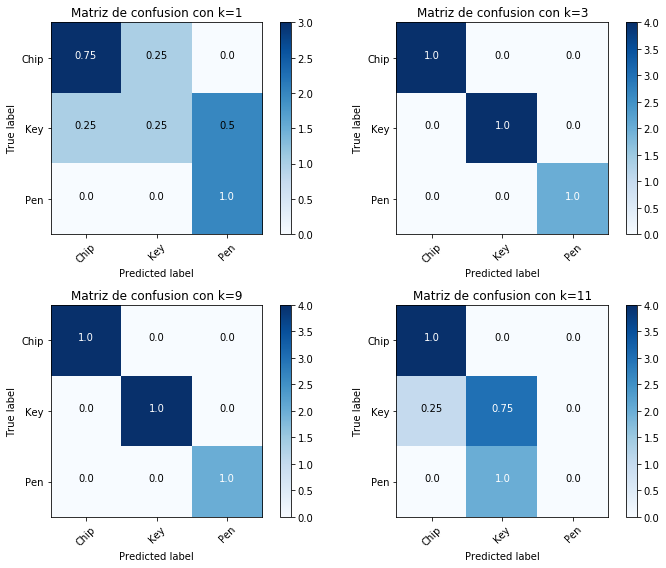

In [46]:
# Inicializando listas con datos
trainData = []     # Vectores de features de imagenes de entrenamiento
responses = []     # Clases verdaderas de imagenes de entrenamiento
testData = []      # Vectores de features de imagenes de prueba
testResponses = [] # Clases verdaderas de imagenes de prueba

# Objeto de la clase kNN_Clasifier
knn = kNN_Clasifier()

# Construyendo los datos de entrenamiento
for file_name in training_files:
    img = cv2.imread("training_set/"+file_name,0)    
    img2 = knn.preprocess(img)
    trainData.append(knn.HuMoments(img2))
    if "chip" in file_name:
        responses.append(0)
    elif "key" in file_name:
        responses.append(1)
    elif "pen" in file_name:
        responses.append(2)

# Entrenando el modelo
knn.train(trainData,responses)

# Construyendo los datos de prueba
for name in testing_files:
    img = cv2.imread("testing_set/"+name,0)
    img3 = knn.preprocess(img)
    testData.append(knn.HuMoments(img3))
    if "chip" in name:
        testResponses.append(0)
    elif "key" in name:
        testResponses.append(1)
    elif "pen" in name:
        testResponses.append(2)

# Probando con diferentes valores de k
fig = plt.figure(figsize=(10,8));
for i,k in enumerate([1,3,9,11]):
    # Obteniendo los resultados (clases predichas) para los datos de prueba y k=k
    resultados = knn.test(testData, k)
    plt.subplot(2,2,i+1)
    
    # Obteniendo la matriz de confusión para k=k
    knn.confusionMatrix(['Chip','Key','Pen'],testResponses,resultados,'Matriz de confusion con k='+str(k));
plt.show()

<p><strong><em>Para tener en cuenta:</em></strong> Podemos ver que el c&oacute;digo realizo muy bien su tarea de clasificaci&oacute;n para chip en la matriz de confusi&oacute;n para k =11 pero por otro lado nunca realizo un buen trabajo con el lapicero, ya que nunca lo clasifico de forma correcta. Con esta misma k, la llave la clasific&oacute; bien la mayor&iacute;a de las veces, pero s&iacute; present&oacute; algo de error. El resultado que se desea siempre es como el presente para la matriz con k = 3 y k=9, ya que todas las im&aacute;genes fueron clasificadas correctamente sin fallar. El otro k que se utilizo fue k=1, y con este el lapicero si fue muy bien clasificado y el chip tambi&eacute;n tuvo buenos resultados, pero para la llave, solo un cuarto de las clasificaciones fueron correctas y fue confundida con las otras dos im&aacute;genes, por lo que se podr&iacute;a decir que este fue el valor de k para el cual se obtuvieron los peores resultados.</p>

<p><strong><em>Otras pruebas:</em></strong>
A continuación se realiza el mismo procedimiento ya mencionado, pero sin la secci&oacute;n de pre procesamiento, debido a que las im&aacute;genes empleadas ya est&aacute;n binarizadas. Se hacen los test y el entrenamiento del modelo. El objeto de la clase kNN_Clasifier de esta secci&oacute;n se llam&oacute; knn2 para que fuera diferente del anterior y poder compararlos, en lugar de sobre escribir el primer modelo.</p>

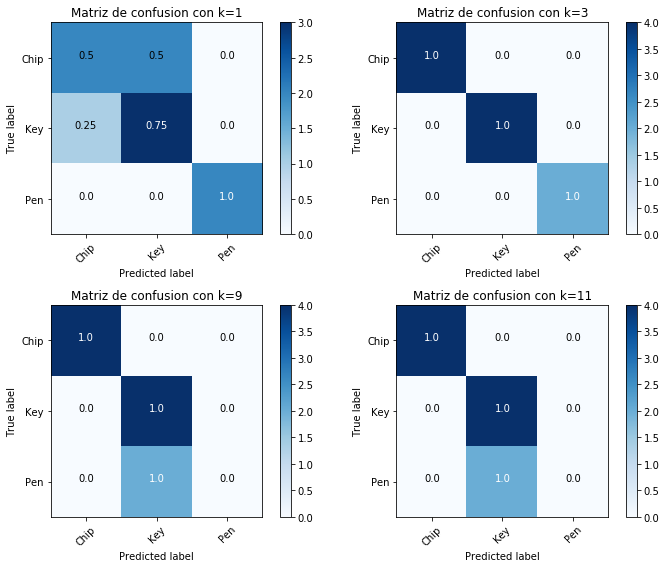

In [41]:
# Inicializando listas con datos
trainData = []     # Vectores de features de imagenes de entrenamiento
responses = []     # Clases verdaderas de imagenes de entrenamiento
testData = []      # Vectores de features de imagenes de prueba
testResponses = [] # Clases verdaderas de imagenes de prueba

# Constructor de clase kNN_Clasifier
knn2 = kNN_Clasifier()

# Construyendo los datos de entrenamiento
for file_name in training_files:
    img = cv2.imread("training_set/Binarized Images/"+file_name,0)
    trainData.append(knn2.HuMoments(img))
    if "chip" in file_name:
        responses.append(0)
    elif "key" in file_name:
        responses.append(1)
    elif "pen" in file_name:
        responses.append(2)

# Entrenando el modelo
knn2.train(trainData,responses)

# Construyendo los datos de prueba
for name in testing_files:
    img = cv2.imread("testing_set/Binarized Images/"+name,0)
    testData.append(knn2.HuMoments(img))
    if "chip" in name:
        testResponses.append(0)
    elif "key" in name:
        testResponses.append(1)
    elif "pen" in name:
        testResponses.append(2)

# Probando con diferentes valores de k
fig = plt.figure(figsize=(10,8));
for i,k in enumerate([1,3,9,11]):
    # Obteniendo los resultados (clases predichas) para los datos de prueba y k=k
    resultados = knn2.test(testData, k)
    
    # Obteniendo la matriz de confusión para k=k
    plt.subplot(2,2,i+1)
    knn2.confusionMatrix(['Chip','Key','Pen'],testResponses,resultados,'Matriz de confusion con k='+str(k));
plt.show()

Al emplear el mismo procedimiento de entrenamiento y clasificaci&oacute;n con las im&aacute;genes que estaban ya binarizadas los resultados fueron de esta forma.</p>
<p>Para k=1 la matriz de confusi&oacute;n muestra que el chip fue clasificado bien solo la mitad de las veces y la llave un poco m&aacute;s de eso (las im&aacute;genes que requer&iacute;an pre procesamiento fueron algo mejor clasificadas en chip pero no tan bien clasificadas para llavs), sin embargo, los resultados para el lapicero fueron muy buenos ya que siempre se clasific&oacute; bien. Para k=3 al igual que con el modelo que requer&iacute;a del pre procesamiento, todas las im&aacute;genes se clasificaron correctamente. Para k=9 el chip y la llave se clasificaron siempre bien, pero por otro lado el lapicero nunca lo fue (en el modelo con pre procesamiento de im&aacute;genes para este k todas las im&aacute;genes recibieron clasificaciones perfectas). &nbsp;Finalmente, para k=11 los resultados fueron iguales que para k=9, con la diferencia que comparado a cuando se deb&iacute;a hacer pre procesamiento, es algo mejor porque en ese chip era clasificado adecuadamente siempre pero el lapicero nunca y la llave solo en un 75% de las veces.</p>
<p>Los resultados no fueron extremadamente diferentes entre los que se realizaron con im&aacute;genes pre procesadas y las que ya ven&iacute;an binarizadas, pero parece que el segundo caso es algo mejor para los k que se probaron, con la diferencia de k=9, donde el primer m&eacute;todo fue mejor.</p>

<p>Para finalizar, a continuación se muestran unos ejemplos del código desarrollado usando una imagen de cada clase de la carpeta de testing. La última función de la clase kNN_Clasifier es __clasify__ la cual realiza los pasos de preprocesamiento, descripción y predicción al ingresar una imagen. Tiene por defecto k=3 pero puede ser modificado.</p>

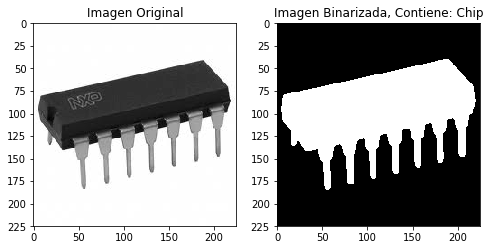

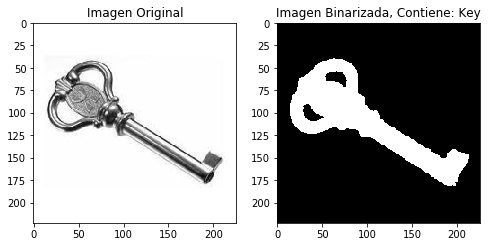

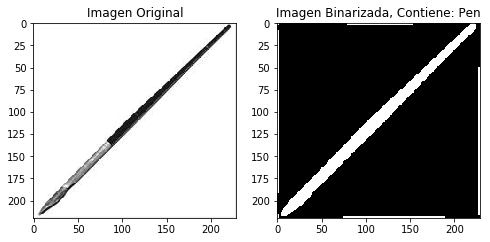

In [47]:
names = ['chip_01.jpg','key_02.jpg','pen_01.jpg']
clases = ['Chip','Key','Pen']
for name in names:
    fig = plt.figure(figsize=(8,5));
    img = cv2.imread("testing_set/"+name,0)
    class_index, img2, _ = knn.clasify(img) # k=3 por default
    plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Imagen Original')
    plt.subplot(1,2,2); plt.imshow(img2, cmap='gray'); plt.title('Imagen Binarizada, Contiene: '+ clases[int(class_index)])
    plt.show()